Our discussion is limited to the methods and models we apply and does not include an in-depth discussion of pyMAISE. For an in-depth tutorial, refer to the [MIT Reactor](https://pymaise.readthedocs.io/en/stable/examples/mit_reactor.html) notebook. For information on the pyMAISE methods used, refer to the [pyMAISE API reference documentation](https://pymaise.readthedocs.io/en/stable/pymaiseapi/index.html).

# BWR Micro Core

**Inputs** 

- `PSZ`: Fuel bundle region Power Shaping Zone (PSZ).
- `DOM`:  Fuel bundle region Dominant zone (DOM).
- `vanA`: Fuel bundle region vanishing zone A (VANA).
- `vanB`: Fuel bundle region vanishing zone B (VANB)
- `subcool`: Represents moderator inlet conditions. Core inlet subcooling interpreted to be at the steam dome pressure (i.e., not core-averaged pressure). The input value for subcooling will automatically be increased to account for this fact. (Btu/lb)?
- `CRD`: Defines the position of all control rod groups (banks).
- `flow_rate`: Defines essential global design data for rated coolant mass flux for the active core, $\frac{kg}{(cm^{2}-hr)}$. Coolant   mass flux equals active core flow divided by core cross-section area. Core cross-section area is DXA 2 times the number of assemblies.
- `power_density`: Defines essential global design data for rated power density using cold dimensions, $(\frac{kw}{liter})$.
- `VFNGAP`: Defines the ratio of narrow water gap width to the sum of the narrow and wide water gap widths.

**Output**

- `K-eff`:  Reactivity coefficient k-effective, the effective neutron multiplication factor.
- `Max3Pin`: Maximum planar-averaged pin power peaking factor.
- `Max4Pin`: maximum pin-power peaking factor, $F_{q}$, (which includes axial intranodal peaking).
- `F-delta-H`: Ratio of max-to-average enthalpy rise in a channel.
- `Max-Fxy`: Maximum radial pin-power peaking factor.

The data set consists of 2000 data points with 9 inputs and 5 outputs. This data set was constructed through uniform and normal sampling of the 9 input parameters for a boiling water reactor (BWR) micro-core. These samples were then used to solve for reactor characteristic changes in heat distribution and neutron flux. This BWR micro-core consists of 4 radially and axially heterogenous assemblies of the same type constructed in a 2x2 grid with a control blade placed in the center. A single assembly composition can be seen in the figure below. A single assembly was brocken into seven zones where each zones 2D radial cross sectional information was constructed using CASMO-4. These cross sectional libraries were then processed through CMSLINK for SIMULATE-3 to interpret. The core geometry and physics was implemented and modeled using SIMULATE-3 [[RFS21]](https://pymaise.readthedocs.io/en/stable/index.html#id3).
    
Note: The reference uses the same model as this example, but the data generated is not the same as the paper.

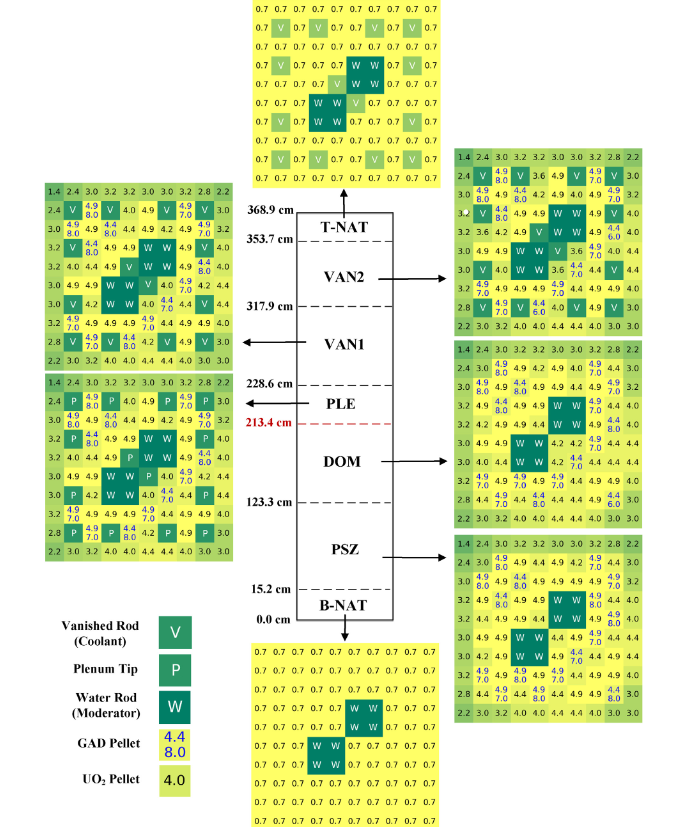

To start off pyMAISE the general packages are used.

In [2]:
from pyMAISE.datasets import load_BWR
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
import pyMAISE as mai

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

We initialize pyMAISE as a regression problem and load the BWR data set.

In [3]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)
data, inputs, outputs = load_BWR()

The BWR micro reactor data set has 9 inputs:

In [4]:
inputs

<xarray.DataArray (index: 2000, variable: 9)>
array([[1.20334e+02, 2.16336e+02, 3.38763e+02, ..., 2.50161e+02,
        6.62500e+01, 2.22000e-01],
       [1.37906e+02, 1.98764e+02, 3.49531e+02, ..., 2.53792e+02,
        6.60440e+01, 3.93000e-01],
       [1.31235e+02, 2.05435e+02, 3.17283e+02, ..., 2.55631e+02,
        6.58390e+01, 4.32000e-01],
       ...,
       [1.11014e+02, 2.25656e+02, 3.04242e+02, ..., 2.47461e+02,
        6.27380e+01, 3.46000e-01],
       [1.10651e+02, 2.26019e+02, 3.11476e+02, ..., 2.54682e+02,
        6.57490e+01, 3.55000e-01],
       [1.17517e+02, 2.19153e+02, 3.46947e+02, ..., 2.50026e+02,
        6.54060e+01, 2.35000e-01]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'PSZ' 'DOM' 'vanA' ... 'power_density' 'VFNGAP'

and 5 outputs with 2000 samples:

In [5]:
outputs

<xarray.DataArray (index: 2000, variable: 5)>
array([[0.95455, 5.105  , 5.303  , 1.861  , 1.899  ],
       [0.98576, 2.839  , 2.904  , 1.436  , 1.816  ],
       [0.95237, 5.161  , 5.43   , 1.846  , 1.903  ],
       ...,
       [0.99524, 2.471  , 2.54   , 1.261  , 1.842  ],
       [0.70601, 7.199  , 7.752  , 1.51   , 1.854  ],
       [0.99079, 2.507  , 2.595  , 1.326  , 1.831  ]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'K-eff' 'Max3Pin' ... 'F-delta-H' 'Max-Fxy'

To better understand the data here is a correlation matrix of the data.

(<Figure size 800x800 with 2 Axes>, <Axes: >)

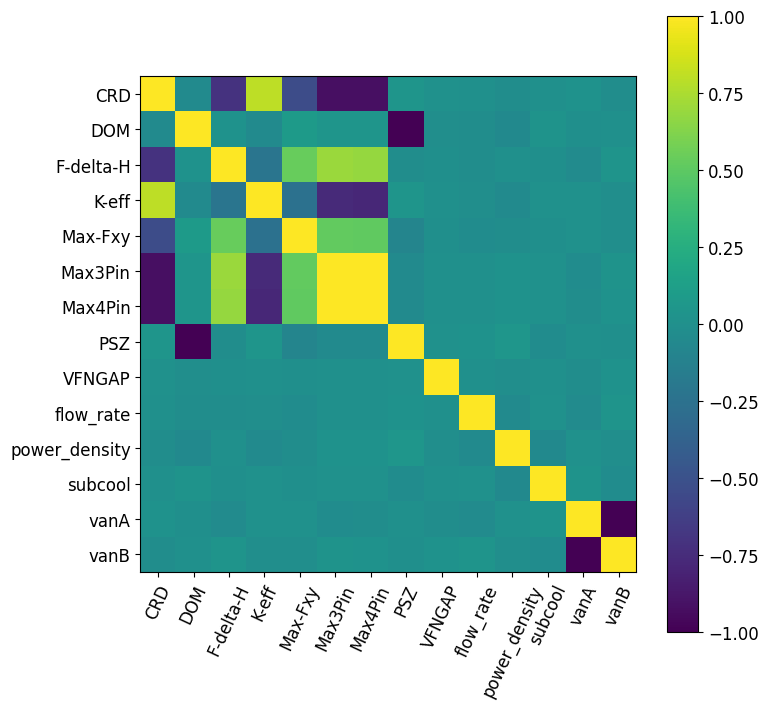

In [6]:
correlation_matrix(data)

As expected there is a strong negative correlation between control rod position (CRD) and the peaking factors. There is also a strong positive correlation between control rod position and k effective.

Prior to model training the data is min-max scaled to make each feature's effect size is comparable. Additionally, this can improve the performance of some models.


In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(data=[inputs, outputs], test_size=0.3)
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

Given this data set has a multi-dimensional output we will compare the performance of 6 machine learning (ML) models:

- Linear regression: `Linear`,
- Lasso regression: `Lasso`,
- Decision tree regression: `DT`,
- Random forest regression: `RF`,
- K-nearest neighbors regression: `KN`,
- Sequential dense neural networks: `FNN`.

For hyperparameter tuing, we initialize all classical models as scikit-learn defaults. For the FNN we define input and output layers with possible dropout layers. These layers include hyperparameter tuning of their number of nodes, use of sublayer, and the rate of dropout. The dense hidden layers include tuning of their depth.

In [8]:
model_settings = {
    "models": ["Linear", "Lasso", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_input": {
                "units": mai.Int(min_value=50, max_value=600),
                "input_dim": xtrain.shape[-1],
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout", "None"]),
                "Dropout": {
                    "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=5),
                "units": mai.Int(min_value=25, max_value=350),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                    "rate": mai.Float(min_value=0.2, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([8, 16, 32, 64]),
            "epochs": 100,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyper-parameter Tuning

We use random search with 200 iterations and 5 cross validation splits (1000 fits per model) for the classical models. The hyperparameter search space is defined for all but linear regression in which the default scikit-learn configuration will be tested. For the FNN we use Bayesian search with 150 iterations and 5 cross validation splits (750 fits total). This offers possible convergence on an optimal configuration without taking an excessive amount of time. Classical models tend to be simpler than neural networks so a large amount of random search iterations are possible.

In [9]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200, 
    cv=5,
)
bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=150,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 150 Complete [00h 00m 21s]
r2_score: 0.4871199766969558

Best r2_score So Far: 0.5931172085503913
Total elapsed time: 01h 56m 37s
Hyperparameter tuning took 144.28097641865412 minutes to process.


Below is the convergence plot for the FNN Bayesian search.

(0.0, 1.0)

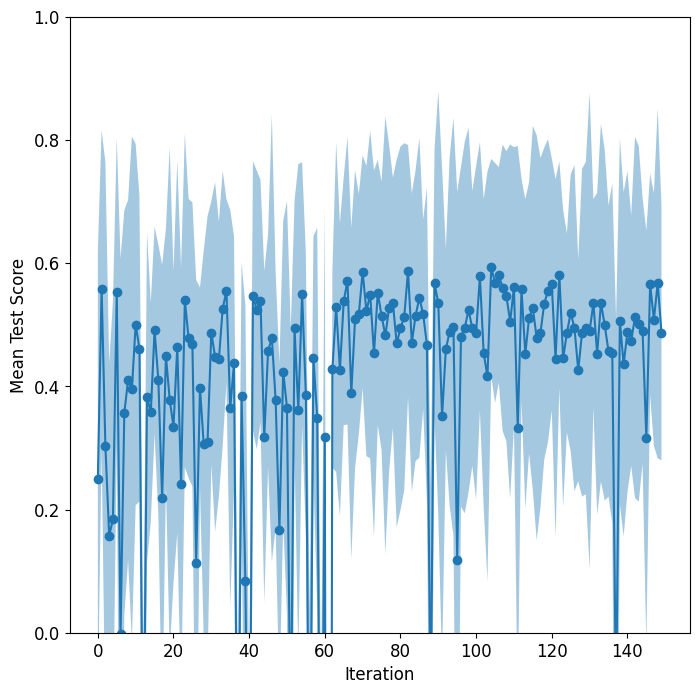

In [10]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])

The search was not able to produce an FNN configuration with performance better than ~0.55 validation $R^2$.

## Model Post-processing

With the models tuned and the top `pyMAISE.Settings.num_configs_saved` saved, we can now pass these models to the `pyMAISE.PostProcessor` for model comparison and analysis. We will increase the `epochs` of the `FNN` models for better performance.

In [11]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 500}},
    },
    yscaler=yscaler,
)

To compare the performance of these models we will compute 4 metrics for both the training and testing data: 

- mean squared error `MSE` $=\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2$, 
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y_i}|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y_i})^2}{\sum^n_{i = 1}(y_i - \bar{y_i})^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\hat{y}$ is the model predicted outcome, and $n$ is the number of observations. The performance metrics for each model are evaluated below for each output starting with `K-eff`.

In [19]:
postprocessor.metrics(y="K-eff")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
11,RF,"{'criterion': 'squared_error', 'max_features':...",0.998813,0.001637,0.000010,0.003109,0.992936,0.003204,0.000051,0.007161
13,RF,"{'criterion': 'squared_error', 'max_features':...",0.997144,0.002562,0.000023,0.004822,0.992473,0.003513,0.000055,0.007392
14,RF,"{'criterion': 'poisson', 'max_features': None,...",0.996955,0.002606,0.000025,0.004979,0.992353,0.003607,0.000056,0.007450
22,FNN,"{'Dense_input_0_units': 600, 'Dense_input_0_su...",0.997964,0.002389,0.000017,0.004072,0.992349,0.003440,0.000056,0.007453
25,FNN,"{'Dense_input_0_units': 359, 'Dense_input_0_su...",0.993403,0.004708,0.000054,0.007329,0.992292,0.004676,0.000056,0.007480
12,RF,"{'criterion': 'squared_error', 'max_features':...",0.999034,0.001395,0.000008,0.002805,0.992222,0.003334,0.000056,0.007514
6,DT,"{'max_depth': 47, 'max_features': None, 'min_s...",0.999011,0.001629,0.000008,0.002837,0.991849,0.003451,0.000059,0.007692
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.996356,0.002832,0.000030,0.005447,0.991673,0.003731,0.000060,0.007775
8,DT,"{'max_depth': 26, 'max_features': None, 'min_s...",0.998364,0.002000,0.000013,0.003650,0.990691,0.003619,0.000068,0.008221
9,DT,"{'max_depth': 47, 'max_features': None, 'min_s...",0.998201,0.002117,0.000015,0.003827,0.990573,0.003667,0.000068,0.008273


In [20]:
postprocessor.metrics(y="Max3Pin")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
11,RF,"{'criterion': 'squared_error', 'max_features':...",0.996170,0.046289,0.009668,0.098326,0.983542,0.084022,0.039931,0.199828
13,RF,"{'criterion': 'squared_error', 'max_features':...",0.989093,0.078460,0.027529,0.165920,0.982241,0.094746,0.043087,0.207575
12,RF,"{'criterion': 'squared_error', 'max_features':...",0.996593,0.039981,0.008598,0.092727,0.981777,0.089190,0.044214,0.210272
14,RF,"{'criterion': 'poisson', 'max_features': None,...",0.987782,0.080380,0.030838,0.175608,0.981265,0.095622,0.045457,0.213206
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.985887,0.085802,0.035621,0.188736,0.979777,0.100672,0.049066,0.221508
25,FNN,"{'Dense_input_0_units': 359, 'Dense_input_0_su...",0.978125,0.131197,0.055214,0.234977,0.973562,0.131042,0.064145,0.253269
6,DT,"{'max_depth': 47, 'max_features': None, 'min_s...",0.997477,0.041595,0.006368,0.079799,0.972735,0.102073,0.066151,0.257198
7,DT,"{'max_depth': 20, 'max_features': None, 'min_s...",0.998320,0.034399,0.004240,0.065118,0.971164,0.100387,0.069963,0.264505
22,FNN,"{'Dense_input_0_units': 600, 'Dense_input_0_su...",0.992623,0.062649,0.018620,0.136456,0.969896,0.102767,0.073041,0.270261
9,DT,"{'max_depth': 47, 'max_features': None, 'min_s...",0.994617,0.057008,0.013586,0.116558,0.968907,0.106677,0.075441,0.274664


In [21]:
postprocessor.metrics(y="Max4Pin")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
11,RF,"{'criterion': 'squared_error', 'max_features':...",0.996222,0.048688,0.011065,0.105192,0.982472,0.090739,0.049334,0.222112
13,RF,"{'criterion': 'squared_error', 'max_features':...",0.989252,0.083040,0.031477,0.177417,0.981303,0.101639,0.052624,0.229400
12,RF,"{'criterion': 'squared_error', 'max_features':...",0.996631,0.041893,0.009865,0.099324,0.980628,0.095413,0.054522,0.233500
14,RF,"{'criterion': 'poisson', 'max_features': None,...",0.988040,0.084789,0.035026,0.187151,0.980226,0.103447,0.055655,0.235913
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.986250,0.089911,0.040269,0.200673,0.978992,0.107854,0.059130,0.243166
25,FNN,"{'Dense_input_0_units': 359, 'Dense_input_0_su...",0.981141,0.123516,0.055232,0.235014,0.973421,0.130403,0.074807,0.273509
7,DT,"{'max_depth': 20, 'max_features': None, 'min_s...",0.998408,0.035763,0.004664,0.068291,0.970504,0.105413,0.083018,0.288128
6,DT,"{'max_depth': 47, 'max_features': None, 'min_s...",0.997785,0.043117,0.006486,0.080535,0.970294,0.109248,0.083610,0.289154
22,FNN,"{'Dense_input_0_units': 600, 'Dense_input_0_su...",0.992567,0.067841,0.021768,0.147540,0.967977,0.110208,0.090130,0.300216
23,FNN,"{'Dense_input_0_units': 600, 'Dense_input_0_su...",0.984344,0.100537,0.045850,0.214126,0.967840,0.131821,0.090516,0.300859


In [22]:
postprocessor.metrics(y="F-delta-H")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
11,RF,"{'criterion': 'squared_error', 'max_features':...",0.997256,0.005974,0.000112,0.010590,0.988793,0.012306,0.000462,0.021493
12,RF,"{'criterion': 'squared_error', 'max_features':...",0.998250,0.004802,0.000072,0.008456,0.988742,0.012169,0.000464,0.021542
13,RF,"{'criterion': 'squared_error', 'max_features':...",0.993371,0.009721,0.000271,0.016459,0.986585,0.014239,0.000553,0.023515
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.992174,0.010852,0.000320,0.017883,0.984642,0.015473,0.000633,0.025161
9,DT,"{'max_depth': 47, 'max_features': None, 'min_s...",0.994934,0.007390,0.000207,0.014389,0.983881,0.013491,0.000664,0.025776
14,RF,"{'criterion': 'poisson', 'max_features': None,...",0.992199,0.010826,0.000319,0.017855,0.983748,0.015862,0.000670,0.025883
8,DT,"{'max_depth': 26, 'max_features': None, 'min_s...",0.995046,0.007194,0.000202,0.014229,0.983513,0.013630,0.000680,0.026069
6,DT,"{'max_depth': 47, 'max_features': None, 'min_s...",0.996815,0.005436,0.000130,0.011409,0.983140,0.012985,0.000695,0.026362
22,FNN,"{'Dense_input_0_units': 600, 'Dense_input_0_su...",0.992984,0.010299,0.000287,0.016933,0.982898,0.016429,0.000705,0.026551
10,DT,"{'max_depth': 10, 'max_features': None, 'min_s...",0.995048,0.007482,0.000202,0.014226,0.980968,0.014463,0.000784,0.028009


In [23]:
postprocessor.metrics(y="Max-Fxy")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
12,RF,"{'criterion': 'squared_error', 'max_features':...",0.994318,0.001919,0.000015,0.003857,0.976351,0.004084,0.000064,0.008011
11,RF,"{'criterion': 'squared_error', 'max_features':...",0.989241,0.002532,0.000028,0.005308,0.969491,0.004352,0.000083,0.009099
13,RF,"{'criterion': 'squared_error', 'max_features':...",0.977401,0.004046,0.000059,0.007693,0.967403,0.005031,0.000088,0.009405
15,RF,"{'criterion': 'poisson', 'max_features': None,...",0.967661,0.005604,0.000085,0.009203,0.959449,0.006736,0.000110,0.010490
14,RF,"{'criterion': 'poisson', 'max_features': None,...",0.970079,0.005144,0.000078,0.008852,0.959161,0.006387,0.000111,0.010527
7,DT,"{'max_depth': 20, 'max_features': None, 'min_s...",0.995771,0.002251,0.000011,0.003328,0.955640,0.005179,0.000120,0.010972
9,DT,"{'max_depth': 47, 'max_features': None, 'min_s...",0.977331,0.003710,0.000059,0.007705,0.952350,0.005152,0.000129,0.011371
8,DT,"{'max_depth': 26, 'max_features': None, 'min_s...",0.983095,0.003458,0.000044,0.006654,0.946952,0.005304,0.000144,0.011998
10,DT,"{'max_depth': 10, 'max_features': None, 'min_s...",0.976042,0.004037,0.000063,0.007921,0.943595,0.005794,0.000153,0.012372
6,DT,"{'max_depth': 47, 'max_features': None, 'min_s...",0.987904,0.002889,0.000032,0.005628,0.937395,0.005348,0.000170,0.013034


In [25]:
postprocessor.metrics()[["Model Types", "Train R2", "Test R2"]]

,Model Types,Train R2,Test R2
12,RF,0.996965,0.983944
11,RF,0.995540,0.983447
13,RF,0.989252,0.982001
14,RF,0.987011,0.979350
15,RF,0.985666,0.978906
7,DT,0.997845,0.973582
9,DT,0.992020,0.972514
8,DT,0.993418,0.971360
6,DT,0.995799,0.971083
10,DT,0.991798,0.969437


Based on the performance metrics presented above, random forest and decision tree are the top performing models. FNN did well on all but `Max-Fxy`. K-nearest neighbors overfit to each output. Linear and lasso regression failed to capture any of the outputs indicating that this data set is nonlinear.

Next the best performing models hyperparameters are shown.

In [32]:
for model in ["Lasso", "DT", "RF", "KN", "FNN"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: Lasso
alpha: 0.0006106351797408914

Model Types: DT
max_depth: 20
max_features: None
min_samples_leaf: 2
min_samples_split: 5

Model Types: RF
criterion: squared_error
max_features: None
min_samples_leaf: 1
min_samples_split: 3
n_estimators: 74

Model Types: KN
leaf_size: 29
n_neighbors: 11
p: 2
weights: distance

Model Types: FNN
Dense_input_0_units: 359
Dense_input_0_sublayer: Dropout
Dense_input_0_sublayer_Dropout_0_rate: 0.6
Dense_hidden_num_layers: 2
Adam_learning_rate: 0.001
Dense_hidden_0_units: 267
Dense_hidden_0_sublayer: None
Dense_hidden_0_sublayer_Dropout_hidden_0_rate: 0.3022307322199378
Dense_hidden_1_units: 200
Dense_hidden_1_sublayer: None
Dense_hidden_1_sublayer_Dropout_hidden_0_rate: 0.2
Dense_hidden_2_units: 25
Dense_hidden_2_sublayer: None
Dense_hidden_2_sublayer_Dropout_hidden_0_rate: 0.2726214031753689
batch_size: 8
Dense_hidden_3_units: 78
Dense_hidden_3_sublayer: None
Dense_hidden_3_sublayer_Dropout_hidden_0_rate: 0.5114958342103242
Dense_hidden_4_u

To visualize the performance of these models we can use the `pyMAISE.PostProcessor.diagonal_validation_plot` functions to produce diagonal validation plots.

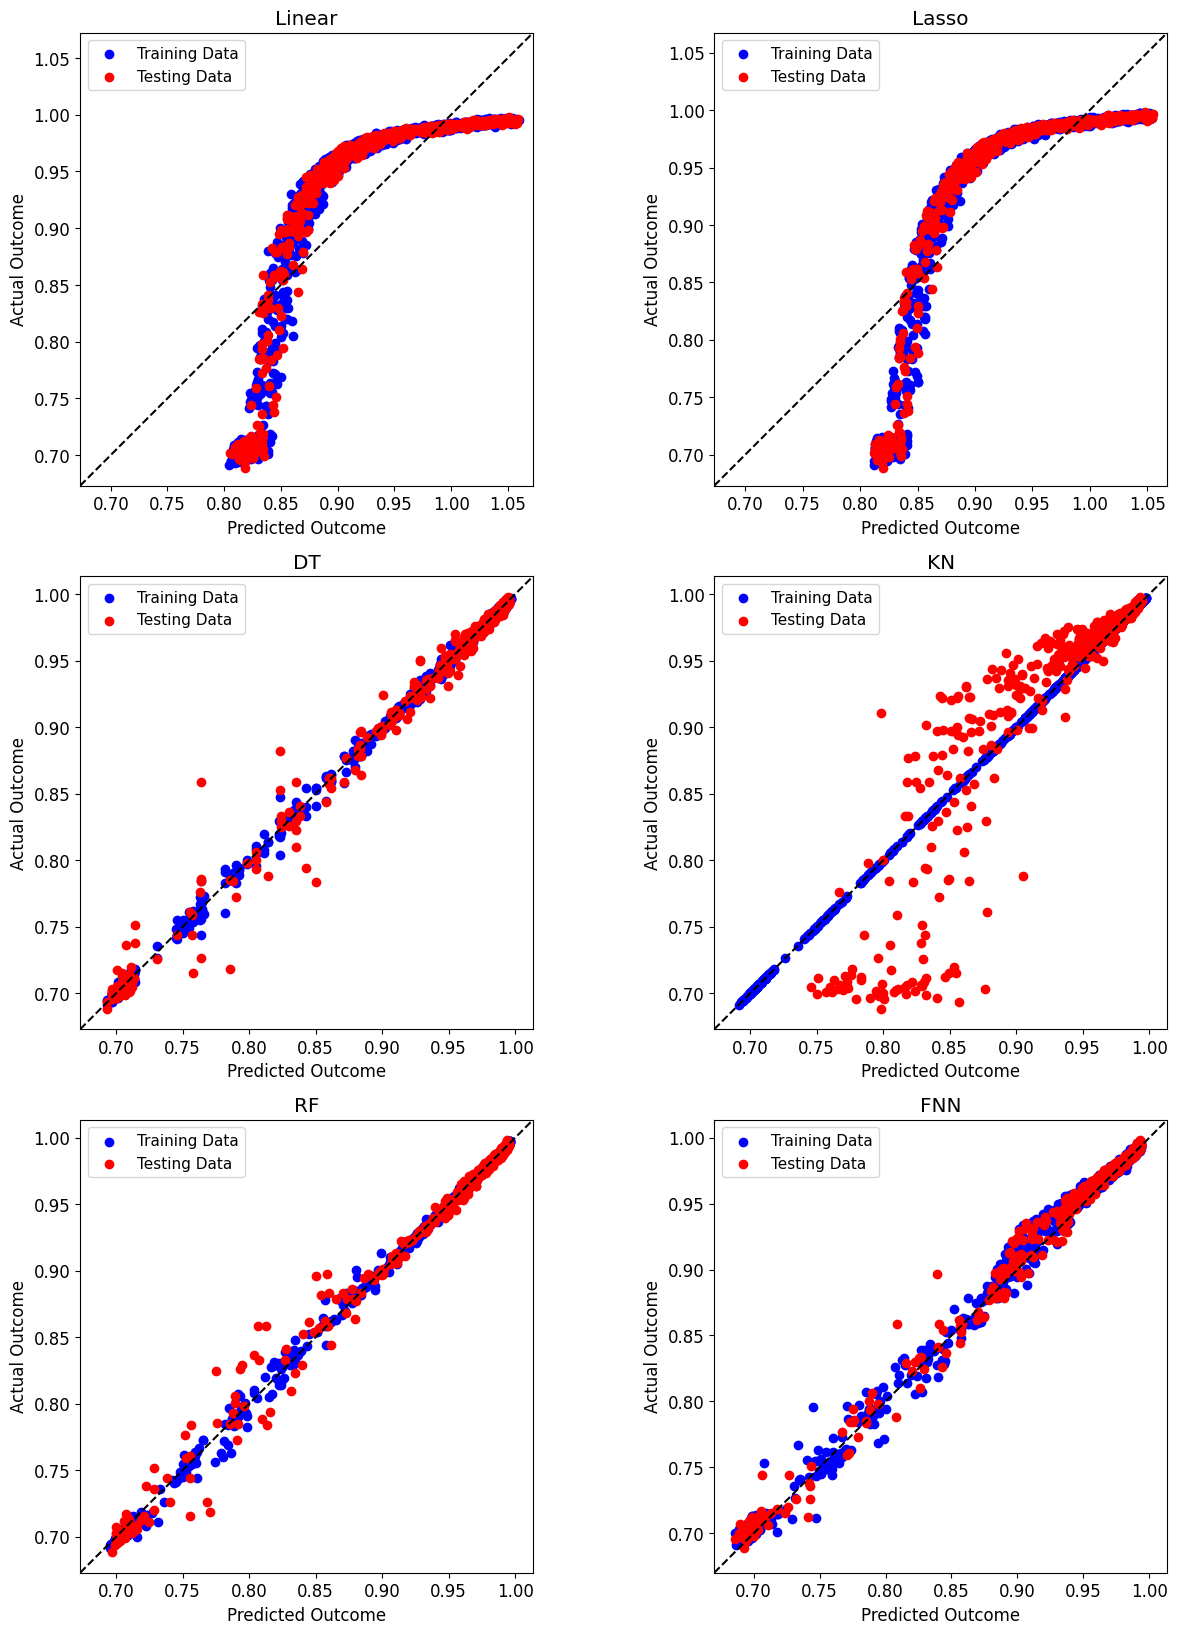

In [27]:
def performance_plot(meth, output):
    models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])
    fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(15,20))
    for i in range(models.shape[0]):
        for j in range(models.shape[1]):
            plt.sca(axarr[i, j])
            axarr[i, j] = meth(model_type=models[i, j], y=[output])
            axarr[i, j].set_title(models[i, j])

performance_plot(postprocessor.diagonal_validation_plot, "K-eff")

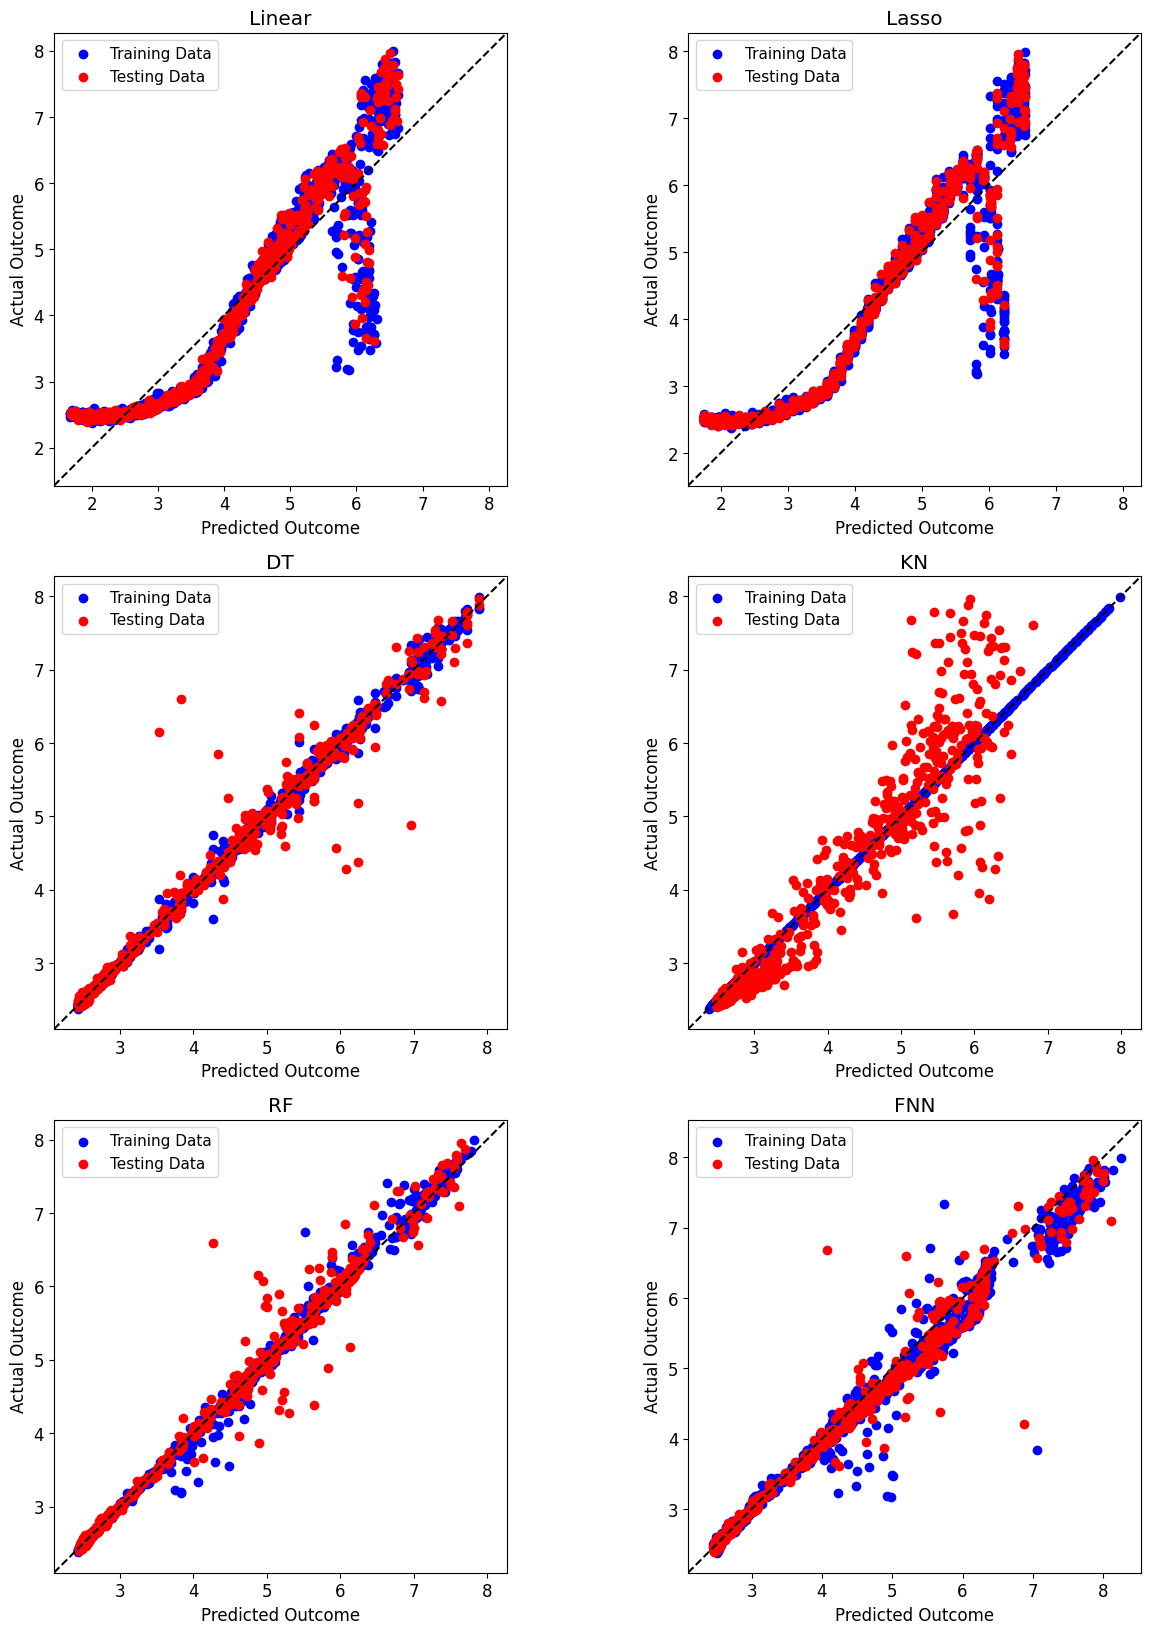

In [28]:
performance_plot(postprocessor.diagonal_validation_plot, "Max3Pin")

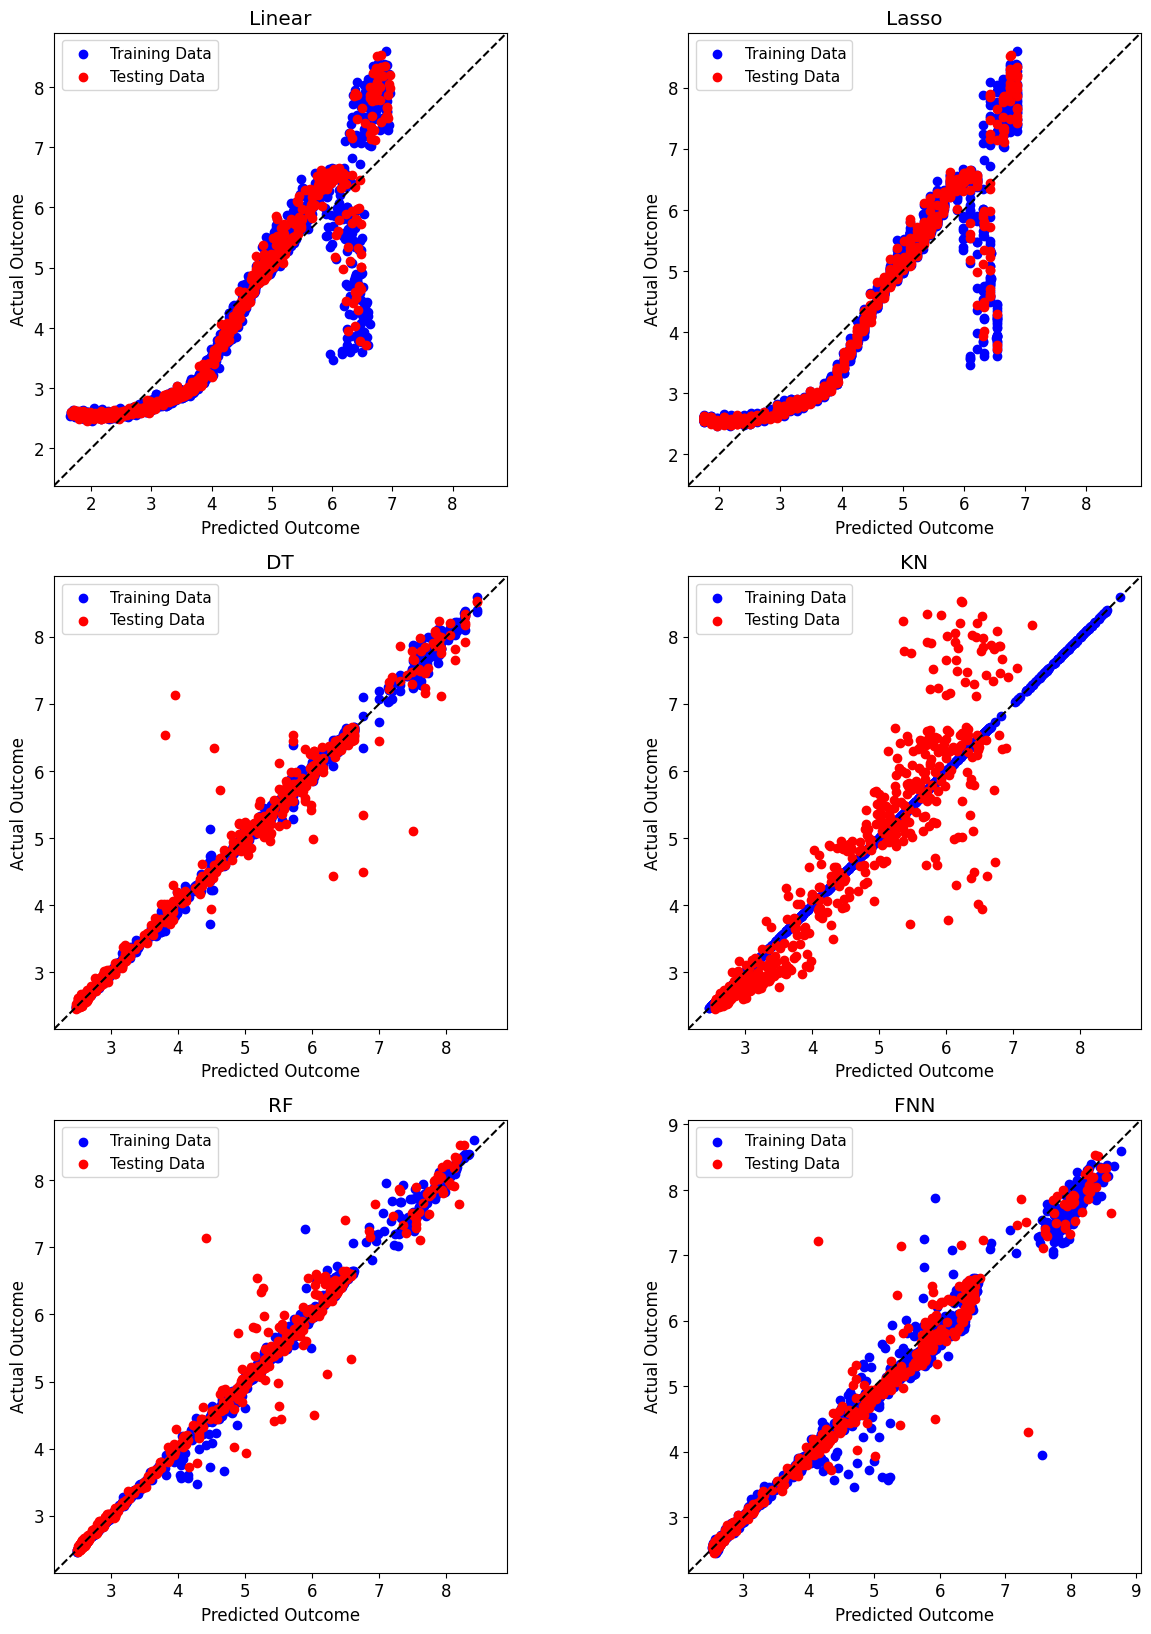

In [29]:
performance_plot(postprocessor.diagonal_validation_plot, "Max4Pin")

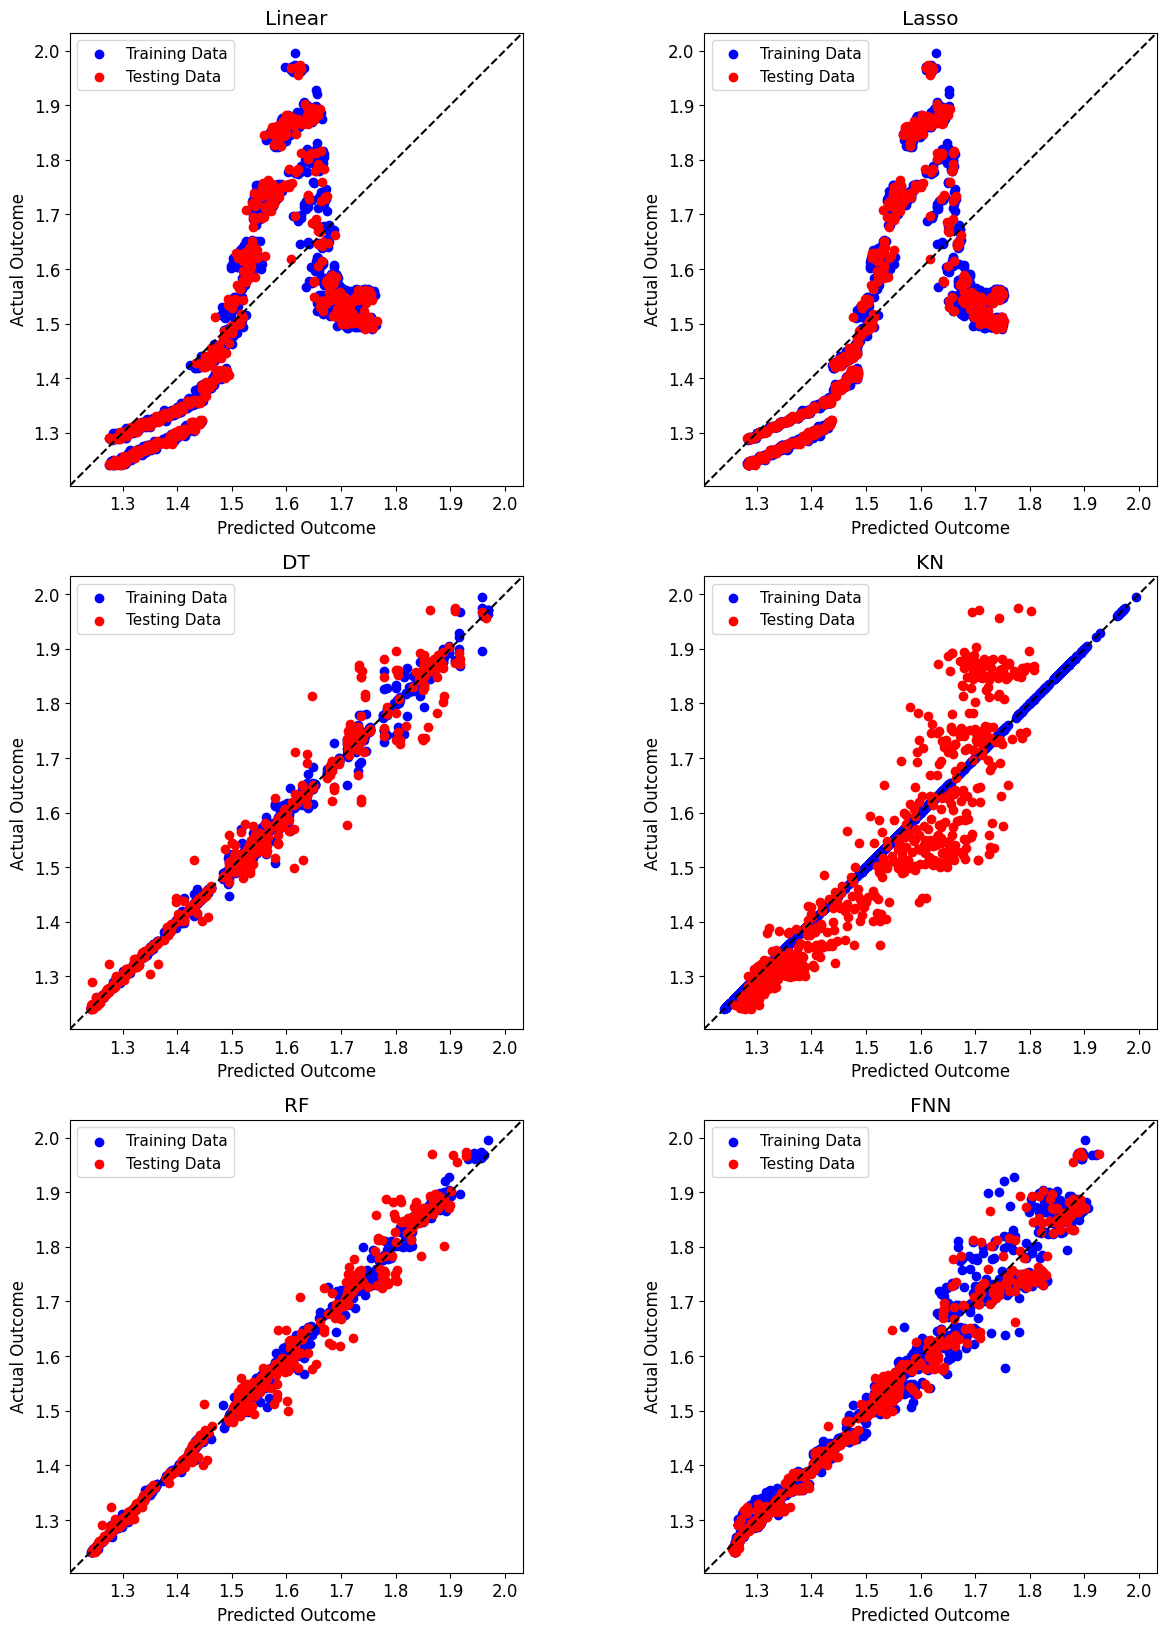

In [30]:
performance_plot(postprocessor.diagonal_validation_plot, "F-delta-H")

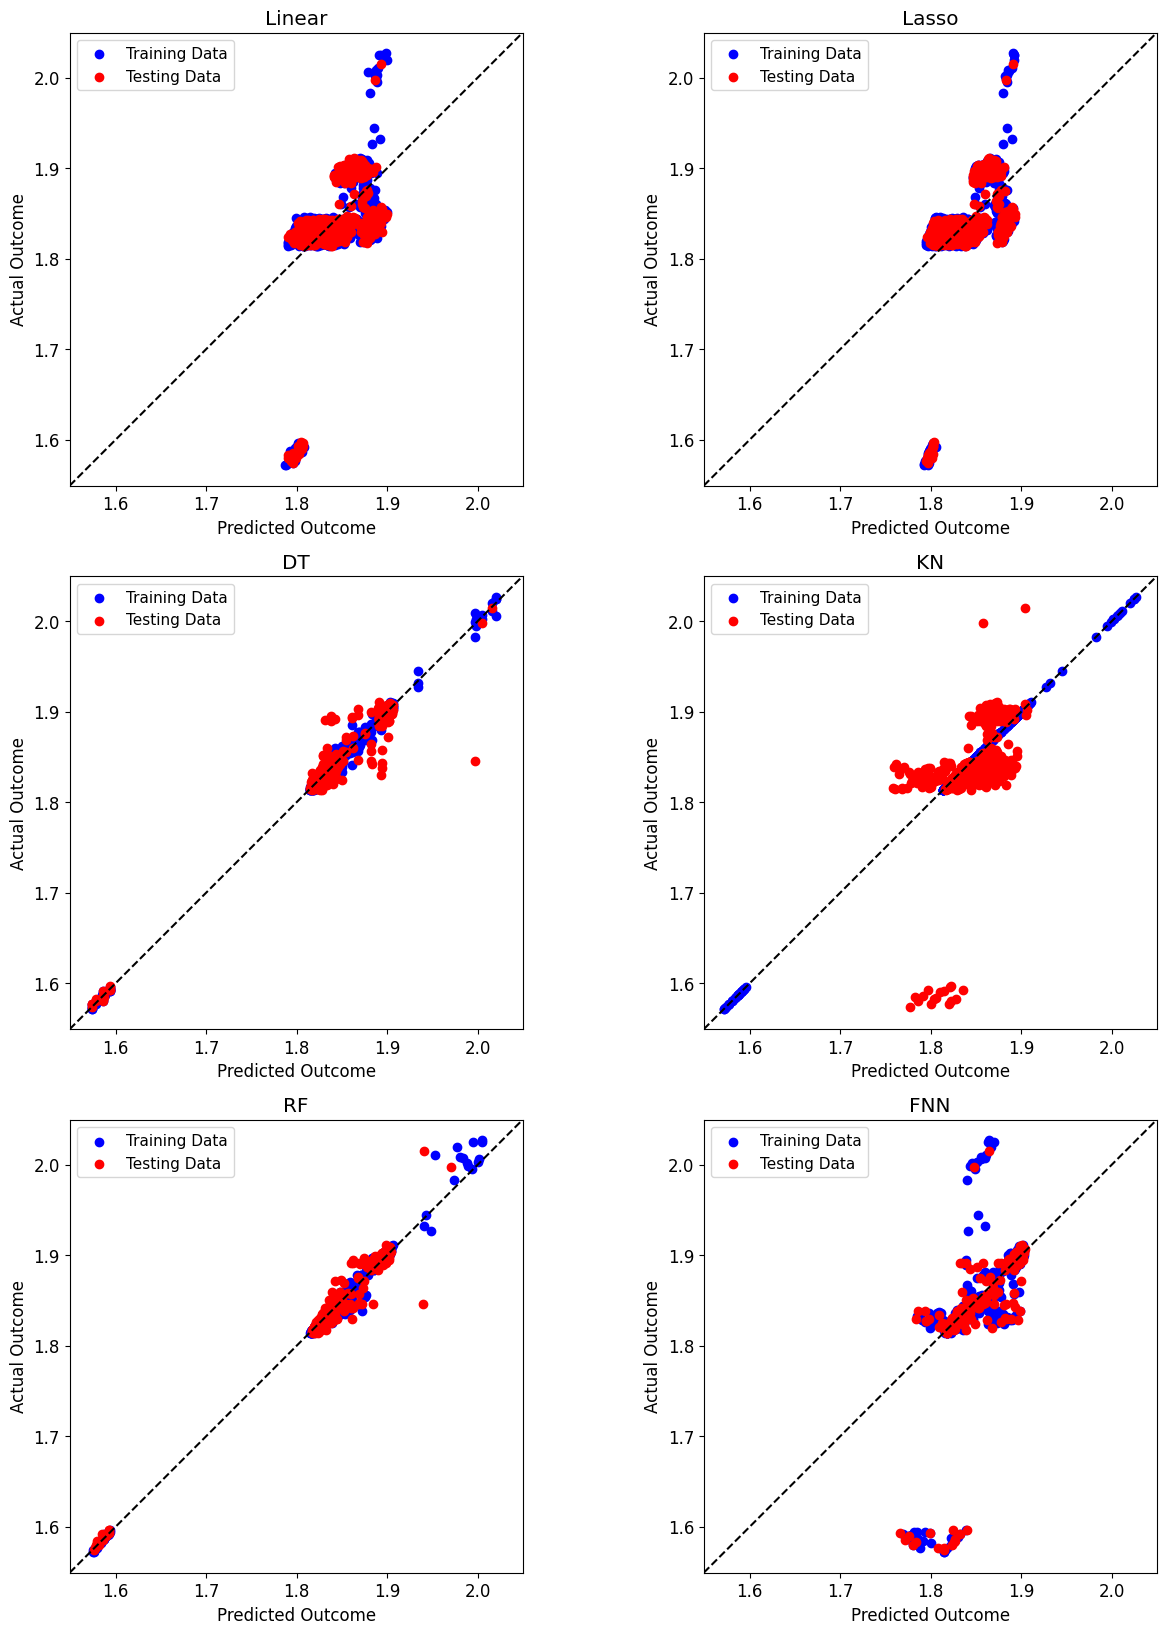

In [31]:
performance_plot(postprocessor.diagonal_validation_plot, "Max-Fxy")

The performance differences between random forest, decision tree, and FNN are minimal except on `Max-Fxy`. For `Max-Fxy` all models showed considerable spread with random forest and decision tree showing the tightest spread. In all the distributions the clear winner is the random forest model. K-nearest neighbors is obviously overfit to the training data.

Similarly, the `pyMAISE.PostProcessor.validation_plot` function produces validation plots that show the absolute relative error for each prediction.

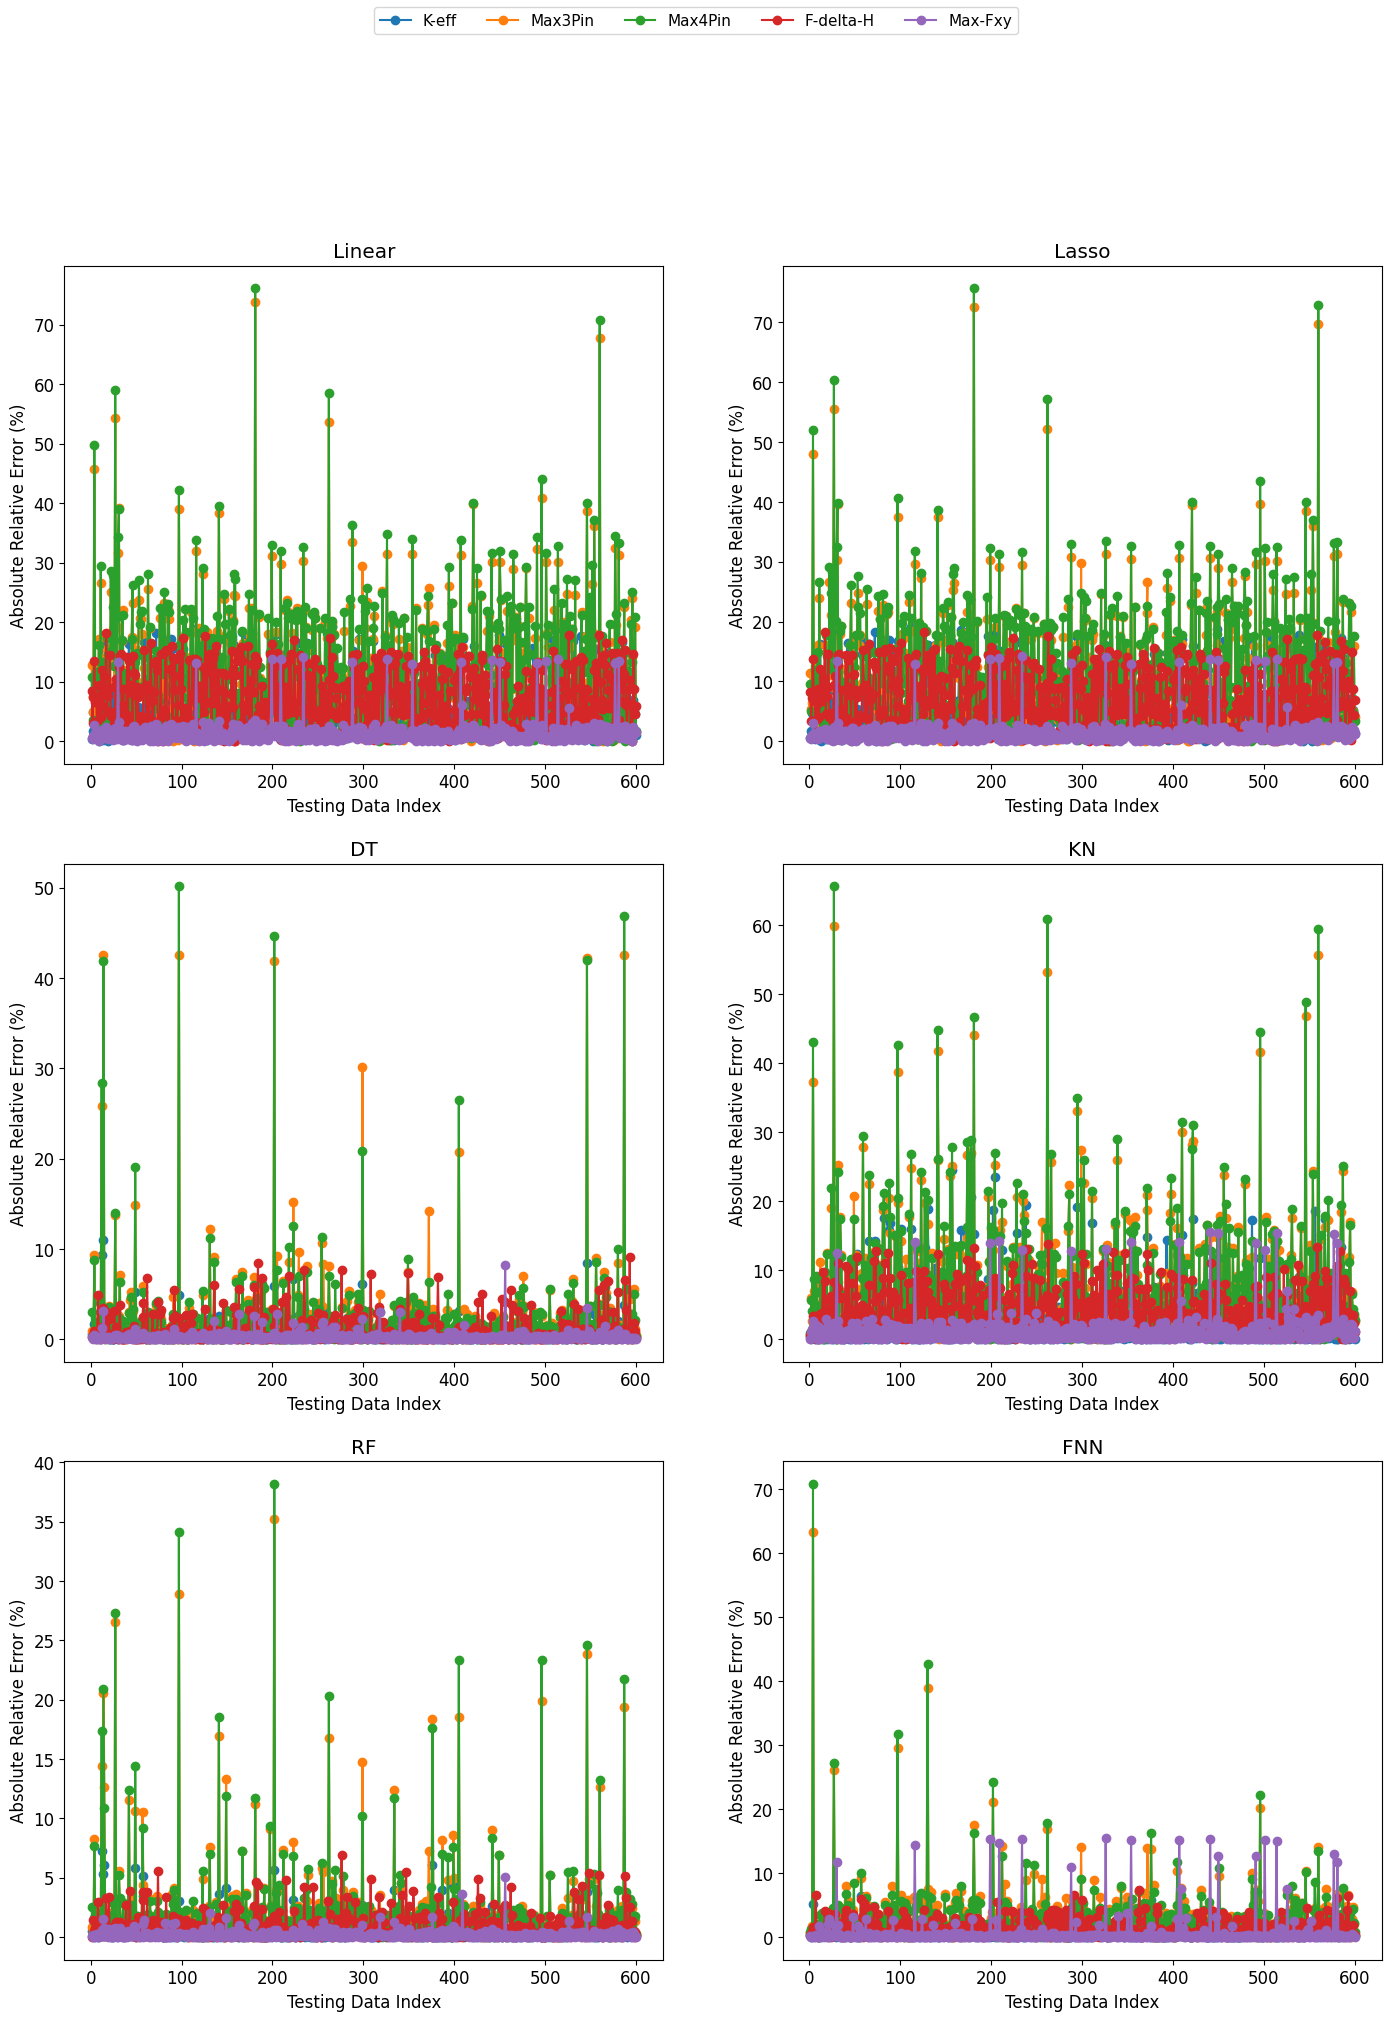

In [33]:
# Output Features and models to plot
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "FNN"]])

# Plot info
fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

# Iterate and plot
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j])
        axarr[i, j].set_title(models[i, j])
        axarr[i, j].get_legend().remove()

fig.legend(["K-eff", "Max3Pin", "Max4Pin", "F-delta-H", "Max-Fxy"], loc="upper center", ncol=5)

The performance of the models is best represented by the magnitudes observed on the y-axis; however, even `RF` and `DT` get as high as $>35\%$ error on `Max3Pin` and `Max4Pin`.

Finally, the learning curve of the most performant FNN is shown by `pyMAISE.PostProcessor.nn_learning_plot`.

<Axes: xlabel='Epoch', ylabel='Loss'>

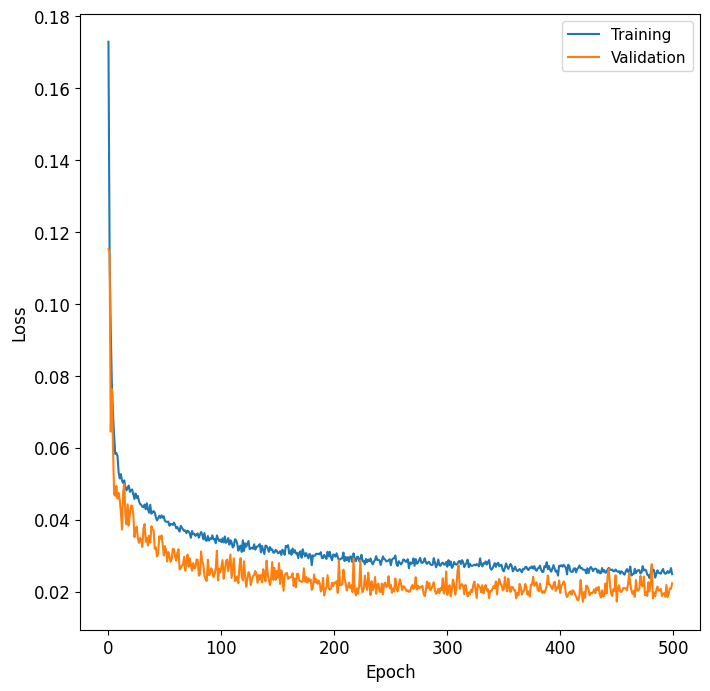

In [34]:
postprocessor.nn_learning_plot()

The FNN is not overfit with the validation curve below the training curve.

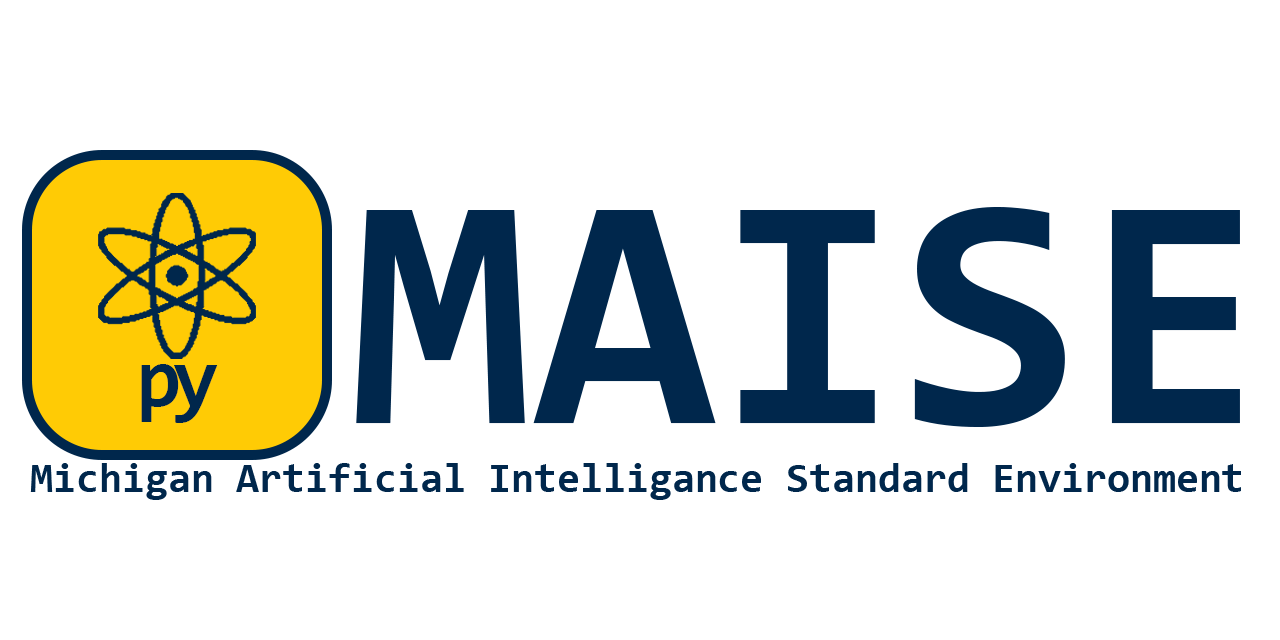